In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('base_data2.csv')
df.drop(['CLASS','DT','YEAR','HML_SI_CAT'],axis=1,inplace=True)
df.head(3)

,HML_SI,HML_SI_BIN,CORR_PRODUCTION,CORR_NC_RATE,CORR_COKE_RATE,CORR_FUEL_RATE,CORR_COAL_RATE,HM_TEMP,QUARTZ_RATE,LIMESTONE_RATE,SLAG_RATE,PYROXINITE_RATE,SINTER_PERC,PELLET_PERC,HOT_BLAST_TEMP,COLD_BLAST_O2_ENRICH,O2_INJ_FLOW,COLD_BLAST_HUMID,FUR_RAFT_TEMP,COMP_COLD_BLAST_FLOW,UPTAKE_AVG,HL_TOTAL_GJ_HR,UPPER_K,MIDDLE_K,LOWER_K,K,HML_S,HML_CAO,HML_SIO2,HML_MGO,HML_AL2O3,HML_CAO_SIO2,COK_MOISTURE,COK_CSR,COK_CRI,COK_AMS,SIN_CAO_SIO2,SIN_MGO
0,0.758,0,6392.38,51.624,361.681,539.236,177.555,1514.714,9.048,0.0,292,17.143,46.972,39.951,1186.936,6.981,22528.467,15.857,2246.775,215.774,119.175,138.406,0.553,0.815,2.201,3.568,0.039,35.683,32.997,9.207,19.463,1.081,0.767,67.31,22.38,37.497,2.437,1.710
1,0.823,0,6398.66,51.730,345.385,531.830,186.445,1509.167,14.762,0.0,298,17.143,49.610,40.000,1187.759,7.000,22554.510,15.600,2219.580,215.272,118.954,133.576,0.575,0.858,2.066,3.500,0.045,34.124,34.620,9.509,19.310,0.986,1.500,67.93,22.96,37.560,2.368,1.792
2,0.806,0,6438.70,51.874,343.703,529.299,185.596,1517.857,6.825,0.0,296,15.238,50.122,39.965,1186.042,6.877,22178.738,15.138,2215.444,215.966,111.061,129.657,0.571,0.733,2.218,3.522,0.039,34.580,33.847,9.435,19.458,1.022,0.833,68.10,23.50,37.424,2.342,1.710


In [ ]:
df.corr()['HML_SI_BIN']

HML_SI                 -0.732145
HML_SI_BIN              1.000000
CORR_PRODUCTION         0.175139
CORR_NC_RATE           -0.032606
CORR_COKE_RATE         -0.219178
CORR_FUEL_RATE         -0.064499
CORR_COAL_RATE          0.238988
HM_TEMP                -0.306938
QUARTZ_RATE            -0.153562
LIMESTONE_RATE         -0.000738
SLAG_RATE               0.127064
PYROXINITE_RATE         0.150131
SINTER_PERC            -0.061611
PELLET_PERC             0.024715
HOT_BLAST_TEMP          0.037404
COLD_BLAST_O2_ENRICH    0.191980
O2_INJ_FLOW             0.164083
COLD_BLAST_HUMID       -0.165389
FUR_RAFT_TEMP          -0.128716
COMP_COLD_BLAST_FLOW   -0.221053
UPTAKE_AVG             -0.110822
HL_TOTAL_GJ_HR         -0.086579
UPPER_K                -0.203202
MIDDLE_K               -0.191863
LOWER_K                 0.012891
K                      -0.181855
HML_S                   0.138720
HML_CAO                 0.121752
HML_SIO2                0.003719
HML_MGO                 0.095085
HML_AL2O3 

In [ ]:
X= df[['CORR_PRODUCTION','CORR_NC_RATE','CORR_COKE_RATE','CORR_COAL_RATE','HM_TEMP','QUARTZ_RATE','LIMESTONE_RATE','SLAG_RATE','PYROXINITE_RATE','SINTER_PERC','PELLET_PERC','HOT_BLAST_TEMP','COLD_BLAST_O2_ENRICH','COLD_BLAST_HUMID','FUR_RAFT_TEMP','COMP_COLD_BLAST_FLOW','UPTAKE_AVG','HL_TOTAL_GJ_HR','UPPER_K','MIDDLE_K','LOWER_K','K','HML_S','HML_SIO2','HML_MGO','HML_AL2O3','HML_CAO_SIO2','COK_MOISTURE','COK_CSR','COK_CRI','COK_AMS','SIN_CAO_SIO2','SIN_MGO']]
y = df.HML_SI

In [ ]:

l=X.columns

In [ ]:
from sklearn.preprocessing import StandardScaler
X = pd.DataFrame(StandardScaler().fit_transform(X))
X.columns = l

In [ ]:
X['COMP_COLD_BLAST_FLOW'].tail()

523   -1.306155
524   -1.493247
525   -1.078227
526   -0.999802
527   -0.348140
Name: COMP_COLD_BLAST_FLOW, dtype: float64

In [ ]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [ ]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,4):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 33 models on 1 predictors in 0.14152169227600098 seconds.
Processed 528 models on 2 predictors in 1.5714962482452393 seconds.
Processed 5456 models on 3 predictors in 16.470415830612183 seconds.
Total elapsed time: 18.25209093093872 seconds.


This returns a `DataFrame` containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

Now we have one big `DataFrame` that contains the best models we've generated along with their RSS:

In [ ]:
models_best.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 1 to 3
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RSS     3 non-null      float64
 1   model   3 non-null      object 
dtypes: float64(1), object(1)
memory usage: 72.0+ bytes


In [ ]:
models_best

,RSS,model
1,280.597305,<statsmodels.regression.linear_model.Regressio...
2,280.368415,<statsmodels.regression.linear_model.Regressio...
3,280.169035,<statsmodels.regression.linear_model.Regressio...


If we want to access the details of each model, no problem! We can get a full rundown of a single model using the `summary()` function:

In [ ]:
models_best["model"]

1    <statsmodels.regression.linear_model.Regressio...
2    <statsmodels.regression.linear_model.Regressio...
3    <statsmodels.regression.linear_model.Regressio...
Name: model, dtype: object

In [ ]:
df['HML_SI_BIN'].corr(df['HM_TEMP'])

-0.30693817791497097

In [ ]:
model = sm.OLS.from_formula("HML_SI~COMP_COLD_BLAST_FLOW+HM_TEMP+COLD_BLAST_HUMID ", data=df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 HML_SI   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     73.12
Date:                Sat, 20 Jun 2020   Prob (F-statistic):           1.61e-39
Time:                        03:46:40   Log-Likelihood:                 758.17
No. Observations:                 528   AIC:                            -1508.
Df Residuals:                     524   BIC:                            -1491.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.8808      0.468     -8.295      0.000      -4.800      -2.962
COMP_COLD_BLAST_FLOW     0.0030      0.000      6.828      0.000       0.002       0.004
HM_TEMP                  0.0026      0.000      8.023      0.000       0.002       0.003
COLD_BLAST_HUMID         0.0052      0.001      8.260      0.000       0.004       0.006
==============================================================================
Omnibus:                        6.958   Durbin-Watson:                   1.315
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.426
Skew:                           0.202   Prob(JB):                       0.0244
Kurtosis:                       3.417   Cond. No.                     2.83e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
print(models_best.loc[3, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 HML_SI   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):             -0.003
Method:                 Least Squares   F-statistic:                             0.4975
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                       0.684
Time:                        03:46:40   Log-Likelihood:                         -581.90
No. Observations:                 528   AIC:                                      1170.
Df Residuals:                     525   BIC:                                      1183.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [ ]:
print(models_best.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 HML_SI   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):             -0.002
Method:                 Least Squares   F-statistic:                             0.5601
Date:                Sat, 20 Jun 2020   Prob (F-statistic):                       0.571
Time:                        03:46:40   Log-Likelihood:                         -582.09
No. Observations:                 528   AIC:                                      1168.
Df Residuals:                     526   BIC:                                      1177.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

This output indicates that the best two-variable model
contains only `Hits` and `CRBI`. To save time, we only generated results
up to the best 7-variable model. You can use the functions we defined above to explore as many variables as are desired.

Rather than letting the results of our call to the `summary()` function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value:

In [ ]:
models_best.loc[1, "model"].rsquared

0.0013104655859120795

Excellent! In addition to the verbose output we get when we print the summary to the screen, fitting the `OLM` also produced many other useful statistics such as adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [ ]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.001310
2    0.002125
3    0.002835
dtype: float64

As expected, the $R^2$ statistic increases monotonically as more
variables are included.

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will
help us decide which model to select. Note the `type="l"` option tells `R` to
connect the plotted points with lines:

Text(0, 0.5, 'BIC')

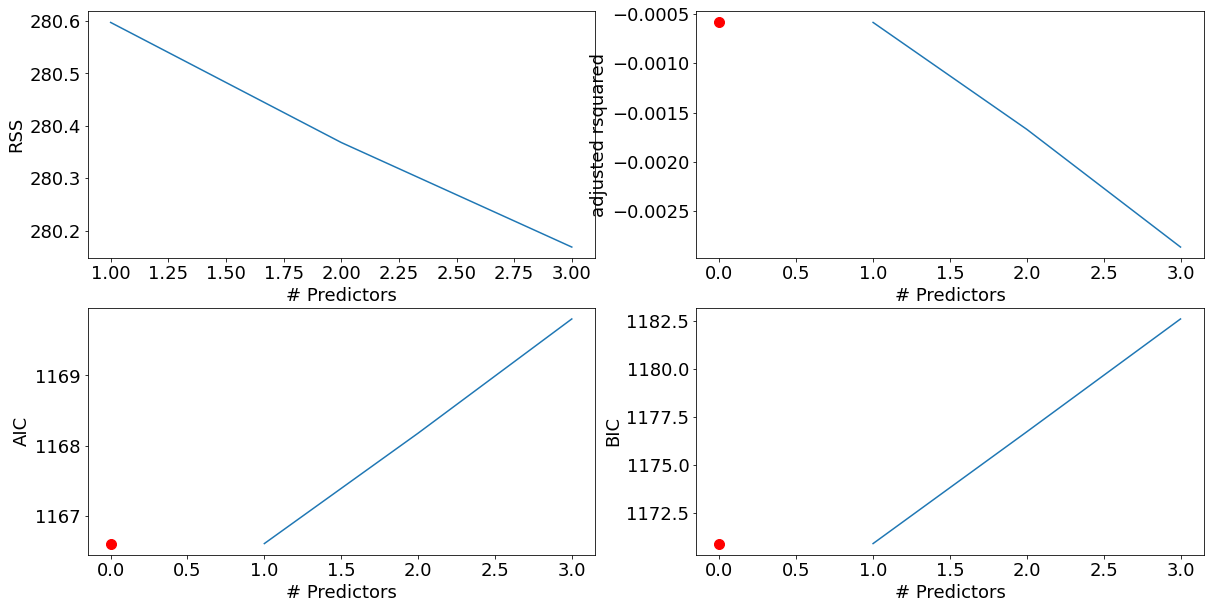

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [ ]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[3, "model"].params)

------------
Best Subset:
------------
HM_TEMP                 0.023670
COLD_BLAST_O2_ENRICH   -0.020574
COLD_BLAST_HUMID        0.021961
dtype: float64
